## 0. Preparation

In [1]:
from pyspark import SparkContext, SparkConf

In [2]:
conf = SparkConf().setAppName("spark-ml").setMaster("local")
sc = SparkContext(conf = conf)

In [3]:
sc

<SparkContext master=local appName=spark-ml>

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pyspark - SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit

# Pyspark - ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [7]:
# Create Spark Session
spark = SparkSession.builder.master('local').appName('titanic').getOrCreate()

In [8]:
# Load Data
df = spark.read.csv('./titanic.csv', header=True, inferSchema=True)
print(type(df))
df.show(5)

<class 'pyspark.sql.dataframe.DataFrame'>
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+---------

- Y 변수: Survived - 0이면 사망, 1이면 생존
- X 변수
    - Pclass(Ticket class): categorical
    - Sex: categorical
    - Age: numeric
    - SibSp(같이 탄 형제/자매 수), Parch(같이 탄 부모 수): numeric
    - Fare(운임료): numeric

In [10]:
# Schema
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



## 1. EDA
### 1) 결측치 확인

In [11]:
from pyspark.sql.functions import isnan, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# 결측치가 많은 Cabin과 Age, 그리고 불필요해보이는 Name과 Ticket, PassengerID은 제외하고 시작하겠습니다.
# 과제 시에는 아래의 링크를 참고해서 다양한 feature를 활용해보세요 !

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [12]:
df = df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+---+-----+-----+----+--------+--------+
|Pclass|Sex|SibSp|Parch|Fare|Embarked|Survived|
+------+---+-----+-----+----+--------+--------+
|     0|  0|    0|    0|   0|       2|       0|
+------+---+-----+-----+----+--------+--------+



In [13]:
# Embark 결측치 처리
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [14]:
# Embarked의 결측치는 최빈값인 'S'로 대체해주기
df = df.na.fill({"Embarked": "S"})
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  168|
|       S|  646|
+--------+-----+



In [15]:
df.printSchema()
print((df.count(), len(df.columns)))

root
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- Survived: integer (nullable = true)

(891, 7)


### 2) Y의 분포 확인하기

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


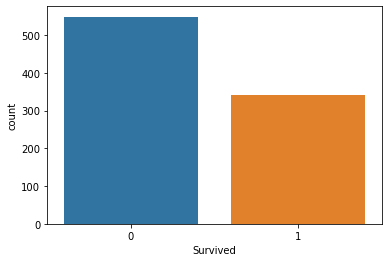

In [19]:
sns.countplot(df.toPandas()['Survived']);

### 3) P(Y|X) 확인하기

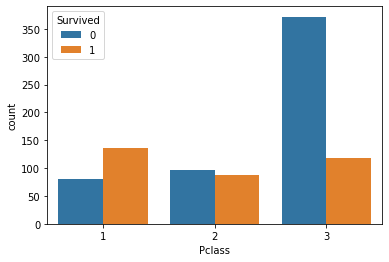

In [21]:
# Pclass -> 높은 등석일수록 생존률이 높음
sns.countplot(data=df.toPandas(), x='Pclass', hue='Survived');

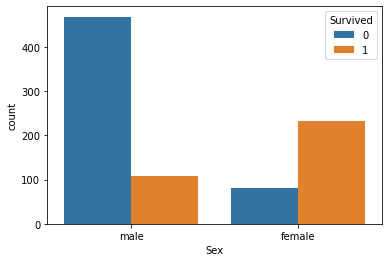

In [22]:
# Sex -> 여성의 생존률이 높음
sns.countplot(data=df.toPandas(), x='Sex', hue='Survived');

In [23]:
# Numeric 변수간의 선형적 상관관계를 나타내는 correlation coefficient
# 생존여부는 Fare(운임료)와 높은 양의 상관관계를 보임
df.toPandas()[['SibSp', 'Parch', 'Fare', 'Survived']].corr()['Survived']

SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

### 4) X 끼리의 분포 확인

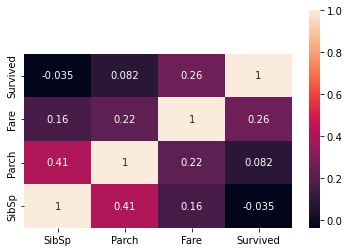

In [24]:
# SibSp - Parch 간의 양의 상관관계
heat = sns.heatmap(df.toPandas()[['SibSp', 'Parch', 'Fare', 'Survived']].corr(), annot=True)
heat.set_ylim(0, 5)
plt.show()

## 2. Feature Engineering
### 1) Feature Selection

In [25]:
# SibSp + Parch는 곧 동행한 가족 수를 의미함
family_count = df['SibSp'] + df['Parch']
df.withColumn("family_count", family_count).corr('family_count', 'Survived')

0.01663898928274521

In [26]:
# SibSp, Parch, SibSp + Parch 중 가장 중요한 변수는 Parch
# Parch만 남겨두고 나머지는 버림
df = df.drop('SibSp')

### 2) OneHotEncoding

In [27]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

enc_pclass = OneHotEncoder(inputCol="Pclass", outputCol="Pclass_onehot")
enc_sex = StringIndexer(inputCol='Sex', outputCol='Sex_onehot')

In [28]:
from pyspark.ml import Pipeline

encoding_pipe = Pipeline(stages=[enc_pclass, enc_sex])
print(type(encoding_pipe))

estimator = encoding_pipe.fit(df)
print(type(estimator))

df_final = estimator.transform(df)
print(type(df_final))

<class 'pyspark.ml.pipeline.Pipeline'>
<class 'pyspark.ml.pipeline.PipelineModel'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [84]:
df_final.show()

+------+------+-----+-------+--------+--------+-------------+----------+
|Pclass|   Sex|Parch|   Fare|Embarked|Survived|Pclass_onehot|Sex_onehot|
+------+------+-----+-------+--------+--------+-------------+----------+
|     3|  male|    0|   7.25|       S|       0|    (3,[],[])|       0.0|
|     1|female|    0|71.2833|       C|       1|(3,[1],[1.0])|       1.0|
|     3|female|    0|  7.925|       S|       1|    (3,[],[])|       1.0|
|     1|female|    0|   53.1|       S|       1|(3,[1],[1.0])|       1.0|
|     3|  male|    0|   8.05|       S|       0|    (3,[],[])|       0.0|
|     3|  male|    0| 8.4583|       Q|       0|    (3,[],[])|       0.0|
|     1|  male|    0|51.8625|       S|       0|(3,[1],[1.0])|       0.0|
|     3|  male|    1| 21.075|       S|       0|    (3,[],[])|       0.0|
|     3|female|    2|11.1333|       S|       1|    (3,[],[])|       1.0|
|     2|female|    0|30.0708|       C|       1|(3,[2],[1.0])|       1.0|
|     3|female|    1|   16.7|       S|       1|    

## 3. Train
### 1) train, test split

In [29]:
df_train, df_test = df_final.randomSplit([0.8, 0.2], seed=0)
print("# of train: {}".format(df_train.count()))
print("# of test: {}".format(df_test.count()))

# of train: 704
# of test: 187


In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

assembler = VectorAssembler(inputCols=['Pclass_onehot', 'Sex_onehot', 'Parch', 'Fare'], 
                            outputCol="features")

lr = LogisticRegression().setFeaturesCol("features").setLabelCol("Survived")
lrModel = Pipeline(stages=[assembler, lr]).fit(df_train)

In [31]:
train_pred = lrModel.transform(df_train).toPandas()['prediction']
train_label = df_train.toPandas()['Survived']
test_pred = lrModel.transform(df_test).toPandas()['prediction']
test_label = df_test.toPandas()['Survived']

In [32]:
from sklearn.metrics import accuracy_score

print(f"Train Score: {100 * accuracy_score(train_pred, train_label):.2f}%")
print(f"Test Score: {100 * accuracy_score(test_pred, test_label):.2f}%")

Train Score: 78.84%
Test Score: 79.14%
